<a href="https://colab.research.google.com/github/karencfisher/hotel-reviews/blob/main/notebooks/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.python.keras.utils.version_utils import TensorBoardVersionSelector
import pandas as pd
import numpy as np
import re
import datetime
import nltk
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_reviews = pd.read_csv('/content/drive/MyDrive/hotel_reviews/reviews.csv')

# Drop date and reviewID columns
df_reviews.drop(columns=['Date', 'ReviewID'], inplace=True)

# Add column for average score (averaging ratings for each review)
cols = df_reviews.columns[:7]
df_reviews['average_score'] = df_reviews[cols].mean(axis=1)

# Drop individual category ratings
df_reviews.drop(columns=cols, inplace=True)

In [ ]:
df_reviews.head()

,Title,Content,average_score
0,“Super stay.”,This the second time we have stayed and this t...,5.000000
1,“Permanent improvements in various aereas to b...,My experience as a rare but regular guest with...,4.571429
2,“span pacific orchard”,Great hotel in good location for night life & ...,4.571429
3,“Great value for money in heart of the shoppin...,The Pan Pac Orchard is in a great location rig...,4.714286
4,“Pan Pacific Orchard”,"Stayed for 3 nights. Hotel is clean, tasty foo...",4.571429


### Distrubution of average scores

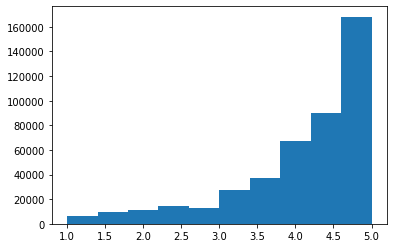

In [ ]:
plt.hist(df_reviews['average_score'], bins=10);

### Sample titles and descriptions by average score

In [ ]:
import textwrap

wrapper = textwrap.TextWrapper(width=140)
for i in range(1, 6):
  print(f'Average Score: {i}')
  cond = df_reviews['average_score'].astype(int) == i
  df_sample = df_reviews[cond].sample(10).sort_values(by='average_score')
  for row in range(len(df_sample)):
    print(df_sample.iloc[row]['Title'], '\n', f'Score = {df_sample.iloc[row]["average_score"]: .2f}')
    text = wrapper.wrap(df_sample.iloc[row]['Content'])
    for w in text:
      print(w)
    print('\n')
  print('*************\n')

Average Score: 1
“mouse” 
 Score =  1.29
went we got there i looked at the place and said OMG this is the worst place we have ever been. the room had paper hanging off on the walls
and the ceiling and the worst was yet to come cause at night we had a MOUSE in the room .....


“I would NEVER recommend this hotel to anyone.” 
 Score =  1.57
I recently traveled to Aguadilla for a wedding & needed a hotel close to Villa Montana beach resort (where the ceremony/reception happened).
There really wasn't a choice about it as the entire the entire wedding party & guests ended up staying at La Cima. We hoped for the best.
Here is my review: Check-in: After a long flight to Aguadilla & EXPENSIVE cab ride ($35 for literally a 2 mile ride) we were greeted by a
front desk person who spoke NO english. He couldn't make our party of 5 extra keys, and there was no one to help us bring bags to our room.
We reserved the 2-bedroom apartment for our group of 5. Ahead of time we requested a cot for the 5th p

### Bucketize reviews into two sentiments, Good vs. Bad

Threshold = average score 3.5

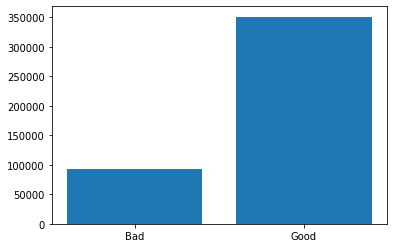

In [ ]:
df_reviews['sentiment'] = df_reviews['average_score'].apply(lambda x: 1 if x >= 3.5 else 0)
plt.bar(['Bad', 'Good'], df_reviews['sentiment'].value_counts().sort_index());

### Clean text

1) Remove curly quotation marks from titles

2) Concatenate titles and description as Content

3) Remove punctuation and stopwords

In [ ]:
nltk.download(['names', 'stopwords'])
stopwords = nltk.corpus.stopwords.words("english")

def cleanText(document):
  text = re.sub('[^a-zA-Z0-9 ]', '', document)
  tokens = text.lower().split()
  tokens = [w for w in tokens if w not in stopwords]
  return " ".join(tokens)

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df_reviews['Title'] = df_reviews['Title'].apply(lambda x: x.replace('“','').replace('”',''))
df_reviews['Content'] = df_reviews['Title'] + ' ' + df_reviews['Content']
df_reviews.drop(columns=['Title'], inplace = True)
df_reviews['Content'] = df_reviews['Content'].apply(cleanText)
df_reviews.sample(10)


,Content,average_score,sentiment
0,super stay second time stayed time son family ...,5.000000,1
1,permanent improvements various aereas highligh...,4.571429,1
2,span pacific orchard great hotel good location...,4.571429,1
3,great value money heart shopping district pan ...,4.714286,1
4,pan pacific orchard stayed 3 nights hotel clea...,4.571429,1
